In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 -4*x + 5

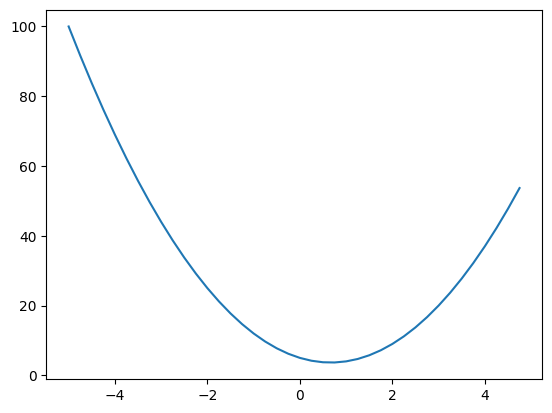

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

## Building data structures to store values and do some basic operations, forward and backward propagation

In [31]:
class Value:
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
        
    def __add__(self, other):
        self = self if isinstance(self,Value) else Value(self)
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad 
            other.grad += out.grad          
        out._backward = _backward
        
        return out

    def __neg__(self):
        return self.data * -1

    def __sub__(self, other):
        return self + (-other)
        
    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
            
        out._backward = _backward
        return out
        
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    # Added automatic backpropation functionality and abstracting it
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1
        for node in reversed(topo):
            node._backward()

In [7]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L

Value(data=-8.0)

In [8]:
a-b

Value(data=5.0)

## Visualizing using graphs

In [9]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [10]:
L.grad = 1

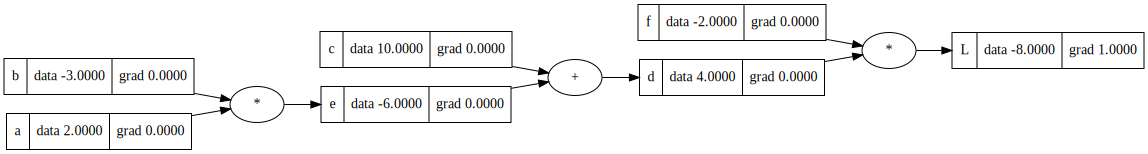

In [11]:
draw_dot(L)

In [12]:
## calculates derivative of a variable (in this case, d) w.r.t L
def lol():
    h = 0.0001
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    d.data += h
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)

lol()

-2.0000000000042206


In [13]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron is b
b = Value(6.8813735870195432, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label="n"
o = n.tanh(); o.label="o"

In [14]:
o.backward()

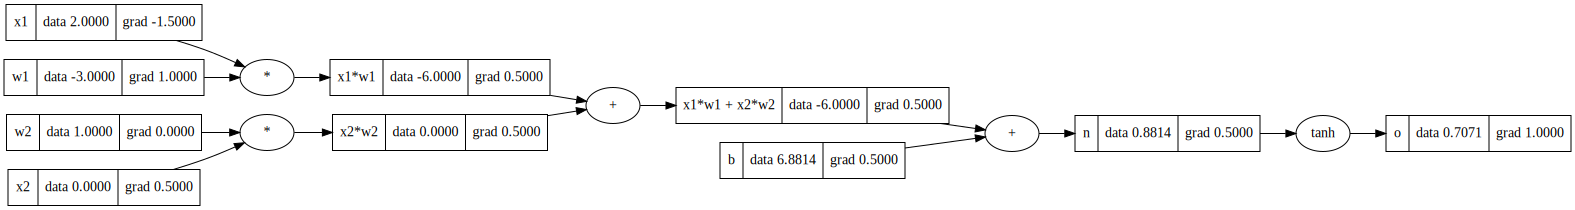

In [15]:
draw_dot(o)

## Breaking tanh to its components

In [16]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron is b
b = Value(6.8813735870195432, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label="n"
# --- Breaking tanh to (e^(2*n)-1)/(e^(2*n)+1)
e = (2*n).exp(); e.label="e^(2*n)"
o = (e-1)/(e+1)
# -------
o.label="o"

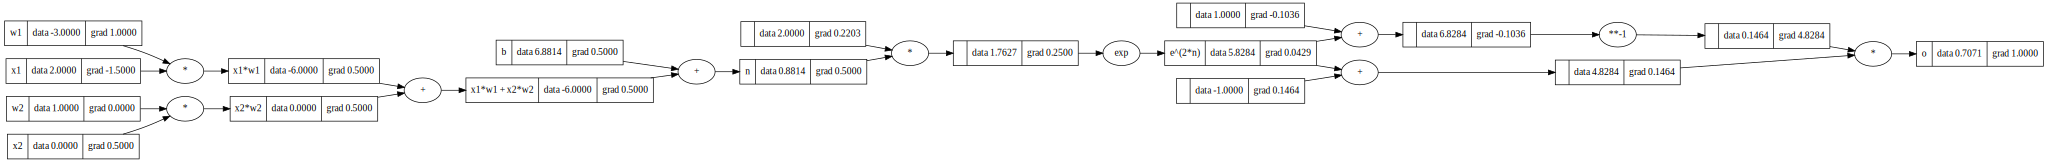

In [19]:
draw_dot(o)

In [18]:
o.backward()

## Automatic backpropagation

### This is my implementation using queue

In [ ]:
o.grad = 1.0
queue = []
queue.append(o)
while queue:
    cur = queue.pop(0)
    cur._backward()
    for node in cur._prev:
        queue.append(node)

### Implementation using recursion (topological sort)

In [ ]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

In [ ]:
o.backward()

## Manual backpropagation

In [ ]:
# o = tanh(n) = (e^2*n - 1)/(e^2*n + 1)
# do/dn = ((e^(2*n) + 1) * 2*e^(2*n) - (e^(2*n) - 1) * 2*e^(2*n))/(e^(2*n) + 1)^2
# do/dn = 4*e^(2*n)/(e^(2*n) + 1)^2 = 1 - tanh^2(n) = sech^2(n) = 1/cosh^2(n)

# do/dn = 1-o^2

In [ ]:
n.grad = 1 - o.data**2

In [ ]:
4*math.exp(2*n.data)/(math.exp(2*n.data) + 1)**2  # just to verify my calculus lol

In [ ]:
x1w1x2w2.grad = 0.5  # same as n.grad
b.grad = 0.5  # same as n.grad

In [ ]:
x1w1.grad = 0.5  # same as x1w1x2w2.grad
x2w2.grad = 0.5

In [ ]:
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

In [ ]:
a = Value(3.0, label="a")
b = a + a; b.label="b"
b.backward()

In [ ]:
draw_dot(b)

## Using PyTorch for forward and backward propagation

In [2]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("--------")
print('x2', x2.grad.item())
print('x1', x1.grad.item())
print("w1", w1.grad.item())
print("w2", w2.grad.item())

0.7071066904050358
--------
x2 0.5000001283844369
x1 -1.5000003851533106
w1 1.0000002567688737
w2 0.0


In [21]:
import random

In [105]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)  # do the sum of Value objects and start the sum with self.b
        out = act.tanh()  # add activation function as hyperbolic tan function
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]



In [198]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.45399210918219696)

In [111]:
n.parameters()

[Value(data=-0.4428002457740394),
 Value(data=-0.3792389860334151),
 Value(data=0.07085294781662),
 Value(data=0.6236543429183323),
 Value(data=-0.47032369833850596),
 Value(data=0.7574146678493794),
 Value(data=-0.6888087808930448),
 Value(data=-0.3429709646261512),
 Value(data=0.7665683471130595),
 Value(data=-0.6533754118403867),
 Value(data=0.43718213143791407),
 Value(data=-0.8643345414904751),
 Value(data=0.9409843196482579),
 Value(data=0.7009215999962943),
 Value(data=-0.9296882187758346),
 Value(data=0.7574238497797781),
 Value(data=-0.3961105630709951),
 Value(data=0.6826559967013062),
 Value(data=0.9150693508816046),
 Value(data=-0.45611248233892265),
 Value(data=0.4809350614201706),
 Value(data=0.40658433210039346),
 Value(data=-0.9660947676003904),
 Value(data=0.24572911068621273),
 Value(data=-0.2682511173741917),
 Value(data=0.08715258267781412),
 Value(data=0.24234284294309716),
 Value(data=0.7685750431186489),
 Value(data=0.7337999074473136),
 Value(data=0.349470921959

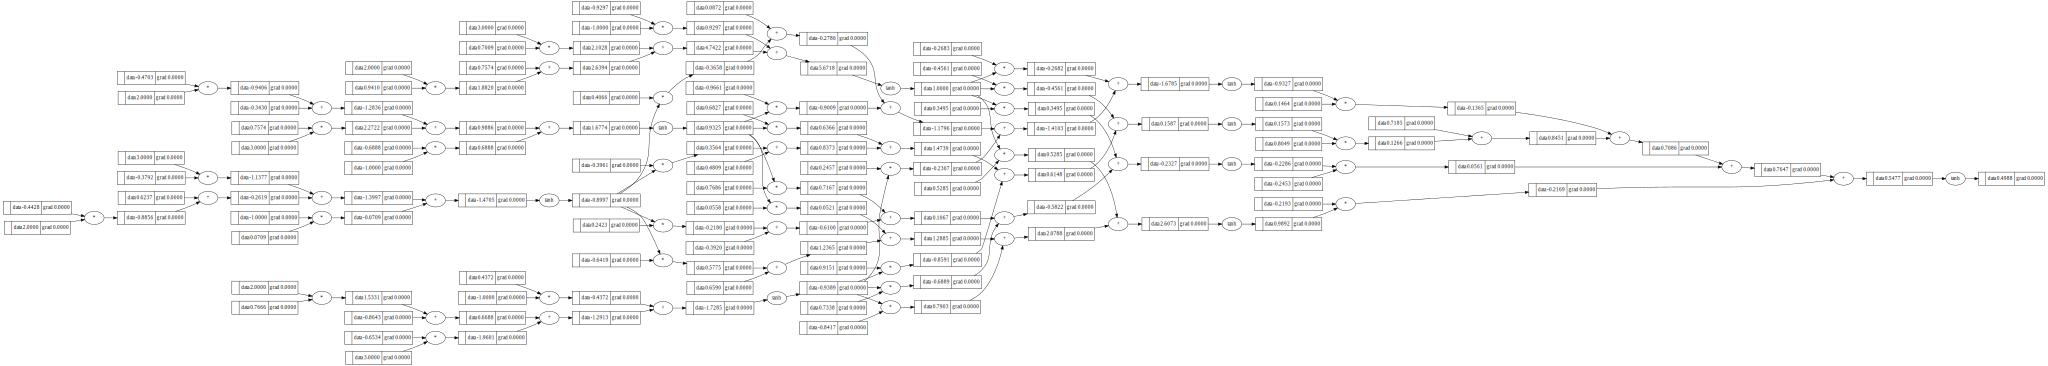

In [107]:
draw_dot(n(x))

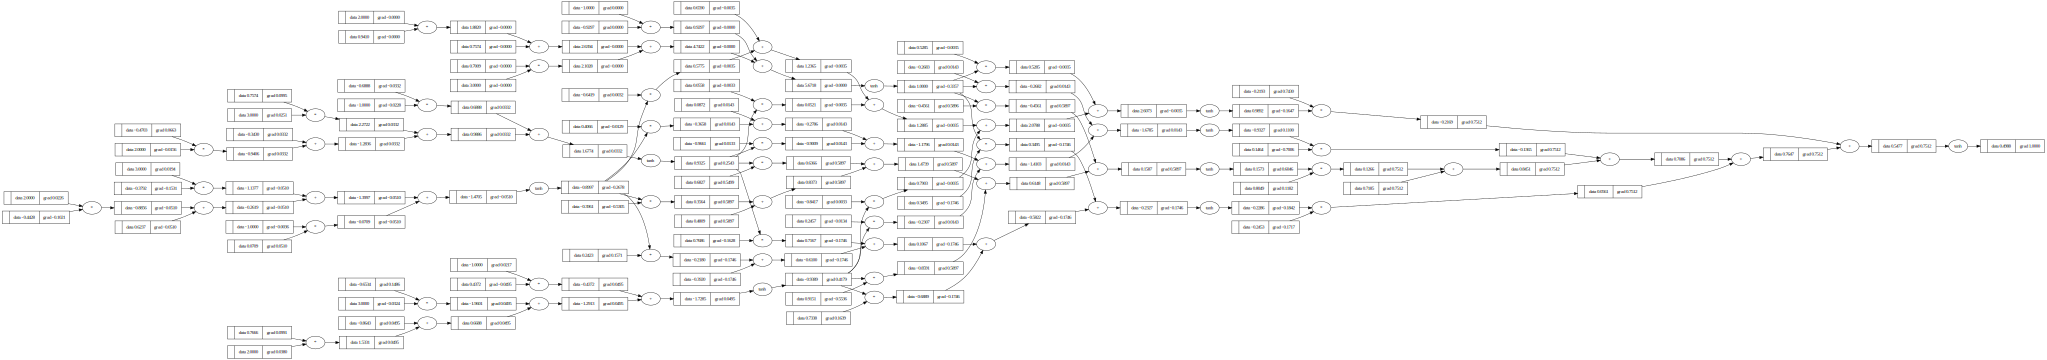

In [108]:
output = n(x)
output.grad = 1
output.backward()
draw_dot(output)

In [123]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]   # desired xs, ys
ypred = [n(x) for x in xs]
ypred

[Value(data=0.4633126949632029),
 Value(data=0.7764905412164312),
 Value(data=0.18510967905085518),
 Value(data=0.2224268411464877)]

In [124]:
# MSE
loss = sum(((yout-ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))
loss

Value(data=5.453056875168559)

In [135]:
loss.backward()

In [139]:
for p in n.parameters():
    p.data += -0.01*p.grad

In [177]:
ypred = [n(x) for x in xs]
# MSE
loss = sum(((yout-ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))
loss

Value(data=0.0007147334857331584)

## Implementing gradient descent for a given number of iterations

In [200]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.45399210918219696),
 Value(data=-0.23963036789042544),
 Value(data=-0.374586806980053),
 Value(data=-0.4252225766956504)]

In [199]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]   # desired xs, ys

In [217]:
# Implementing the gradient descent for a given number of iterations
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    # MSE
    loss = sum(((yout-ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()  # update the gradients of n according to loss
    # Change the params according to the gradient updated
    for p in n.parameters():
        p.data += -0.05 * p.grad
    print(k, loss.data)

0 0.0013853987163195375
1 0.0013804685375280838
2 0.0013755726217367448
3 0.0013707106160658292
4 0.001365882172440837
5 0.0013610869475113529
6 0.0013563246025713454
7 0.0013515948034811963
8 0.0013468972205912483
9 0.0013422315286668782
10 0.0013375974068151092
11 0.0013329945384125915
12 0.0013284226110350825
13 0.0013238813163883078
14 0.0013193703502401323
15 0.0013148894123541058
16 0.0013104382064243344
17 0.001306016440011494
18 0.0013016238244802172
19 0.001297260074937708


In [218]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9832293107992669),
 Value(data=-0.9890146307892623),
 Value(data=-0.9813774489726207),
 Value(data=0.9766720950267245)]